In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import collections
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
import cv2
import glob
import networkx as nx
from tqdm import tqdm
from enum import Enum
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xml.etree.ElementTree as et 
from dataset import create_dataset
from gym.envs.hyrule.hyrule_env import HyruleEnv

In [33]:
def print_img(image, pano_angle, high_res=True):
    x = (int(image.shape[1] * env.agent_dir) +  int(image.shape[1] * pano_angle/360)) % image.shape[1]
    w = image.shape[0]
    if (x + w) % image.shape[1] != (x + w):
        if high_res:
            img = np.zeros((1024, 1024, 3))
        else:
            img = np.zeros((84, 84, 3))
        offset = (x + w) % image.shape[1]
        offset1 = image.shape[1] - (x % image.shape[1])

        img[:, :offset1, :] = image[:, x:x + offset1]
        img[:, offset1:, :] = image[:, :offset]
        img = img.astype(int)
    else:
        img = image[:, x:x + w]
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.imshow(img)
    plt.show()

In [20]:
create_dataset(region="saint-urbain")

Loading thumbnails: 100%|██████████| 57/57 [00:20<00:00,  2.81it/s]
/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['angle', 'thumbnail', 'x', 'y', 'z']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->['frame', 'obj_type', 'house_number', 'label_coords']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [34]:
env = HyruleEnv()
obs = env.reset()

env.agent_pos:15
angle1:178.19581141639105


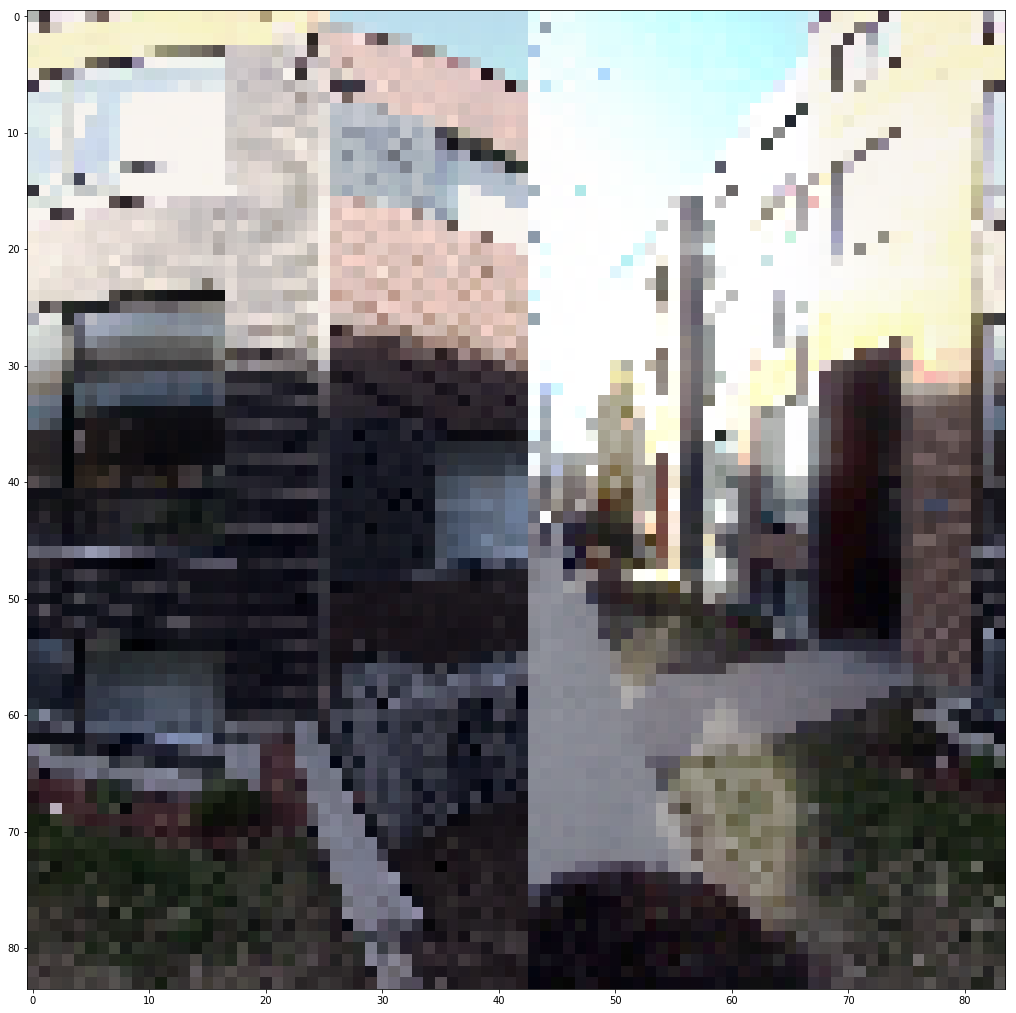

[16, 14]
{16: 0.9747182684694887, 14: 0.06428393199354349}
env.agent_pos:14
angle2:171.24779709023449


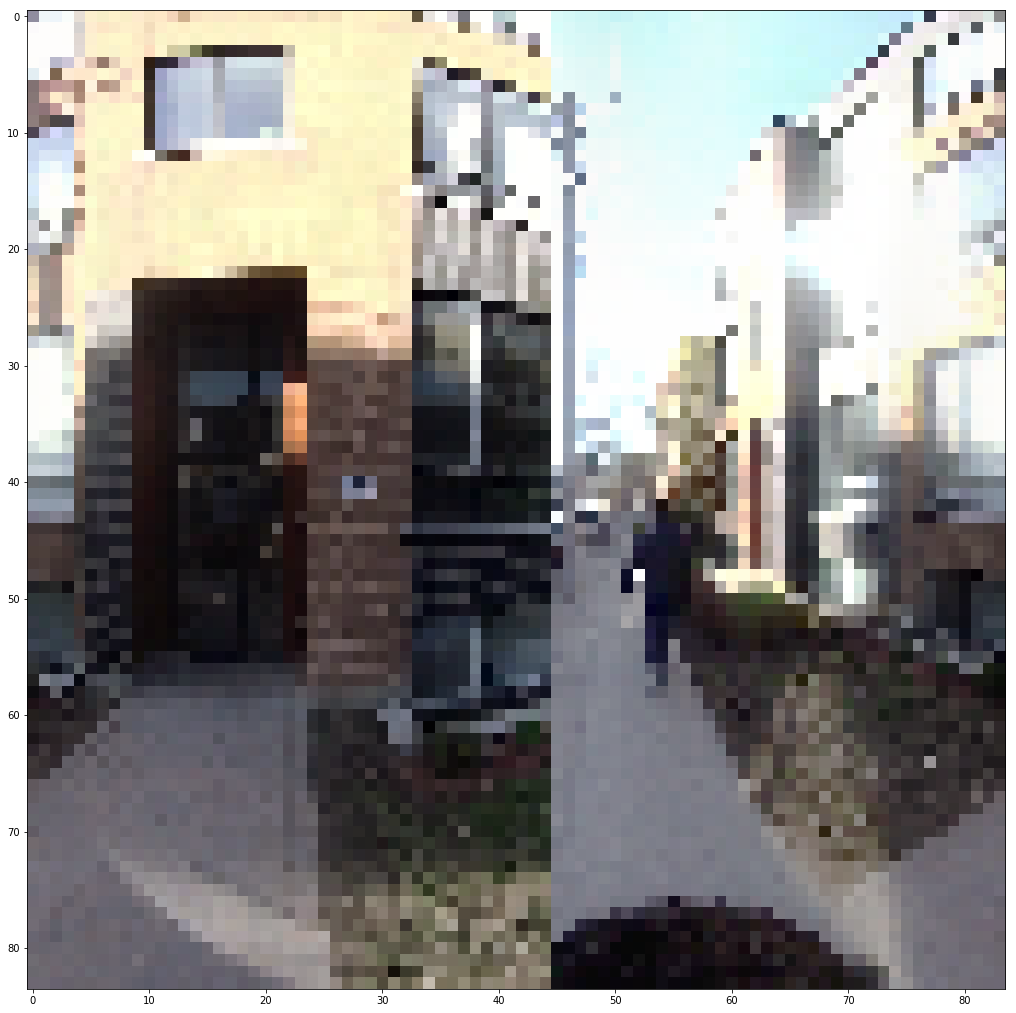

In [60]:
# Get two sequential panos
edge_angles = {}
env.agent_dir = 0./360.
env.agent_pos = 15 #np.random.choice(env.G.nodes)

angle1 = env.G.node[env.agent_pos]['angle']
image1 = env._get_image()
print("env.agent_pos:"+str(env.agent_pos))
print("angle1:"+str(angle1))
print_img(image1, angle1, high_res=False)


# img = cv2.imread(filename="data/saint-urbain/panos/pano_frame_"+ str(env.agent_pos).zfill(6) + ".png")
# img = img[:, :, ::-1]
# pano_angle = env.data_df.iloc[frame]['angle']
# print_img(img, pano_angle)

neighbors = [edge[1] for edge in list(env.G.edges(env.agent_pos))]
print(neighbors)
for n in neighbors:
    sink_coords = env.G.nodes[n]['coords']
    o = sink_coords[1] - env.G.nodes[env.agent_pos]['coords'][1]
    h = np.linalg.norm(env.G.nodes[n]['coords'][0:2] - env.G.nodes[env.agent_pos]['coords'][0:2])
    angle = np.arcsin(o/h)/np.pi + 0.5
    edge_angles[n] = np.abs(angle - env.agent_dir)
print(edge_angles)

env.agent_pos = min(edge_angles, key=edge_angles.get)
angle2 = env.G.node[env.agent_pos]['angle']
image2 = env._get_image()
print("env.agent_pos:"+str(env.agent_pos))
print("angle2:"+str(angle2))
print_img(image2, angle2, high_res=False)


# img = cv2.imread(filename="data/saint-urbain/panos/pano_frame_"+ str(env.agent_pos).zfill(6) + ".png")
# img = img[:, :, ::-1]
# pano_angle = env.data_df.iloc[frame]['angle']
# print_img(img, pano_angle)


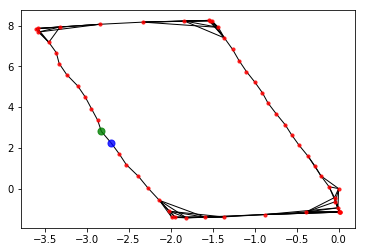

In [61]:
pos = {k: v.get("coords")[0:2] for k, v in env.G.nodes(data=True)}

nx.draw_networkx_nodes(env.G, pos,
                       nodelist=env.G.nodes - {14, 15},
                       node_color='r',
                       node_size=10,
                   alpha=0.8)

# First node is Green
nx.draw_networkx_nodes(env.G, pos,
                       nodelist={15},
                       node_color='g',
                       node_size=50,
                   alpha=0.8)

# Second node is blue
nx.draw_networkx_nodes(env.G, pos,
                       nodelist={14},
                       node_color='b',
                       node_size=50,
                   alpha=0.8)
edges = nx.draw_networkx_edges(env.G, pos=pos)


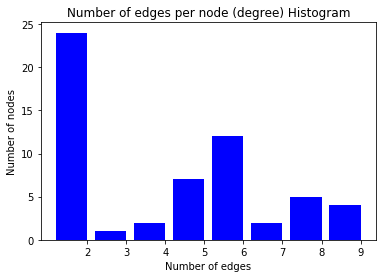

In [57]:
# This was just useful to visualize the number of edges per node
degree_sequence = sorted([d for n, d in env.G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Number of edges per node (degree) Histogram")
plt.ylabel("Number of nodes")
plt.xlabel("Number of edges")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()
